In [4]:
import os
import sys
import json
import pywt
import pickle
import corner
import importlib

try:
    import mpmath
    from tqdm import tqdm
    from pyne2001 import get_dm_full
    from mwprop.ne2001p import *
    from mwprop.ne2001p.NE2001 import ne2001
    from lmfit import minimize, Parameters, fit_report, Model
except:
    # Suppress the output with > /dev/null 2>&1
    os.system('pip install mpmath > /dev/null 2>&1')
    os.system('pip install tqdm > /dev/null 2>&1')
    os.system('pip install lmfit > /dev/null 2>&1')
    os.system('pip install mwprop > /dev/null 2>&1')
    os.system('pip install pyne2001 > /dev/null 2>&1')
    
    import mpmath
    from tqdm import tqdm
    from pyne2001 import get_dm_full
    from mwprop.ne2001p import *
    from mwprop.ne2001p.NE2001 import ne2001
    from lmfit import minimize, Parameters, fit_report, Model

import numpy as np
import scipy as sp
from scipy.fft import fft2, fftshift
from scipy.signal import savgol_filter, resample, correlate, fftconvolve

from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, Planck15
import astropy.units as u

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['cmr10']
rcParams['font.size'] = 27
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = False
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = False

########################################## IMPORTS BASEPATH ##############################################
imports_basepath = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scattering/'
sys.path.insert(0,imports_basepath)
##########################################################################################################

# Utility function script
import burstfittools as bft
importlib.reload(bft)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
def dedisperse(data,dm,fch1=1498.75,reffreq=1530.,nf=6144,df=0.03051757812,nt=32768,dt=32.768e-3):
    
    # calculate number of samples in output
    delay = 4.149377593360996*dm*((1e-3*(fch1-(nf-1)*df))**(-2.) - (1e-3*reffreq)**(-2.))
    nsamp_delay = int(delay/dt)-1
    nsamp_output = nt-nsamp_delay
    print('outputting samples:',nsamp_output)
    
    # form output
    output_data = np.zeros((nf,nsamp_output))
    for i in np.arange(nf):
        
        f = 1e-3*(fch1-i*df)
        delay_samples = 4.149377593360996*dm*(f**(-2.) - (1e-3*reffreq)**(-2.))/dt
        x = np.arange(nsamp_output)+delay_samples
        xp = np.arange(nt)
        fp = data[i,:]
        output_data[i,:] = np.interp(x,xp,fp)
        
    return output_data

def bandpasscorr_first(initrow, OFF_PULSE_INDICES_TIME):
    #Effective bandpass correction
    row = (initrow - np.nanmean(initrow[OFF_PULSE_INDICES_TIME])) / np.nanstd(initrow[OFF_PULSE_INDICES_TIME])
    return row

def bandpasscorr_sec(arr, OFF_PULSE_INDICES_TIME):
    arr = [bandpasscorr_first(row, OFF_PULSE_INDICES_TIME) for row in arr]
    arr = np.asarray(arr)
    arr = np.nan_to_num(arr)
    return arr

Data File: casey_dsa_I_491_211_2500b_cntr_bpc.npy


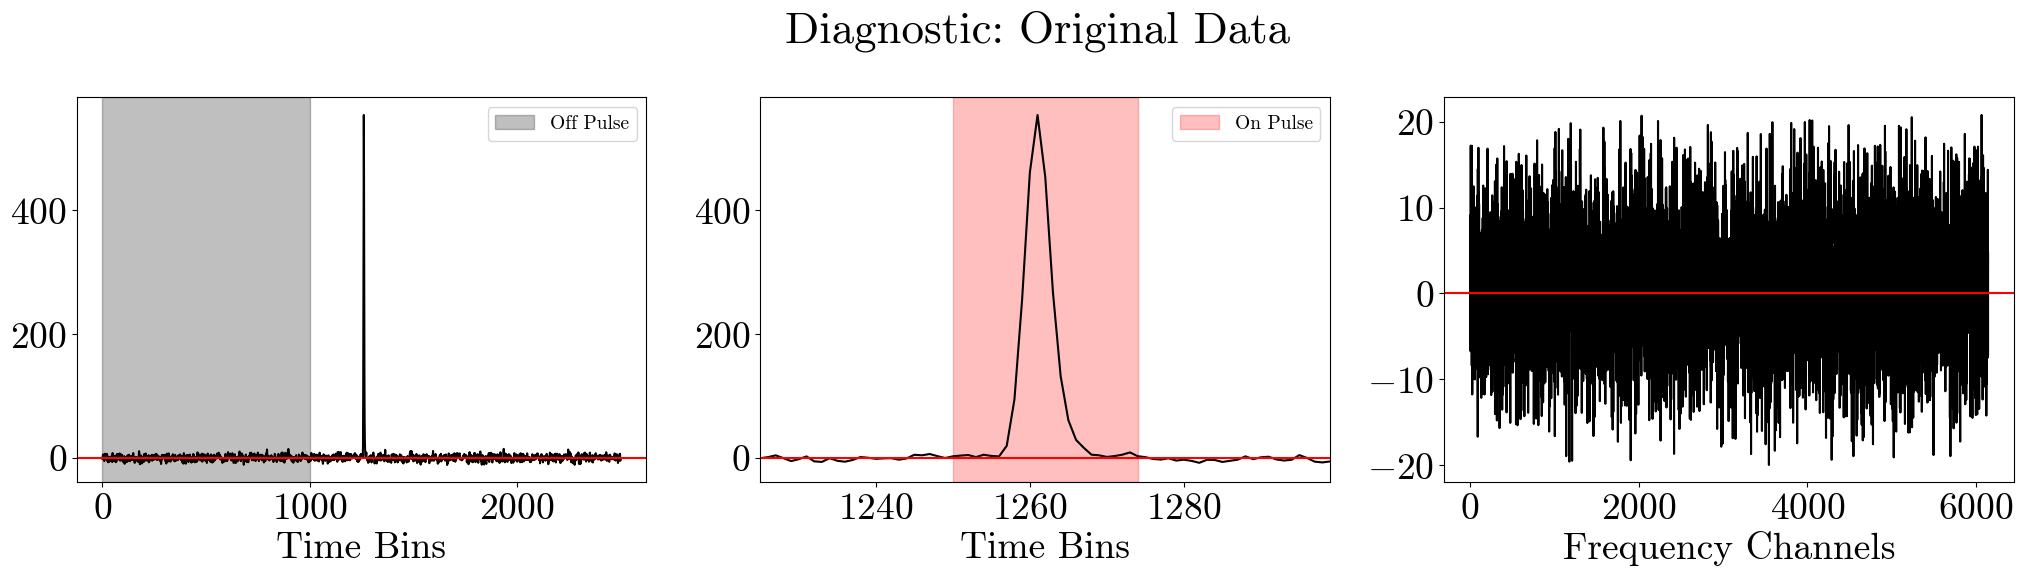

In [3]:
# Load data
name = 'casey'
basedir = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/'
npys = os.listdir(f'{basedir}')
npy = [i for i in npys if f'{name}' in i][0]
print(f'Data File: {npy}')
data = np.load(os.path.join(basedir, npy))
data = np.nan_to_num(data)

OFF_PULSE_INDICES_TIME = np.arange(0, 1000)
ON_PULSE_INDICES_TIME = np.arange(1250, 1275)

#print(OFF_PULSE_INDICES_TIME)
time = np.arange(0, data.shape[1])
test_timeseries = np.nansum(data, axis = 0)
test_spectrum = np.nansum(data, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 5))
ax1.plot(time, test_timeseries, c='k')
ax1.set_xlabel('Time Bins')
ax1.axhline(0, c = 'r')
ax1.axvspan(OFF_PULSE_INDICES_TIME[0], OFF_PULSE_INDICES_TIME[-1], alpha=0.25, color='k', label='Off Pulse')
ax1.legend(fontsize=14)

ax2.set_xlabel('Time Bins')
ax2.plot(time, test_timeseries, c='k')
ax2.set_xlim(ON_PULSE_INDICES_TIME[0]-25, ON_PULSE_INDICES_TIME[-1]+25)
ax2.axhline(0, c = 'r')
ax2.axvspan(ON_PULSE_INDICES_TIME[0], ON_PULSE_INDICES_TIME[-1], alpha=0.25, color='r', label='On Pulse')
ax2.set_xlabel('Time Bins')
ax2.legend(fontsize=14)
ax2.set_title('Diagnostic: Original Data \n')

ax3.plot(test_spectrum, c='k')
ax3.axhline(0, c = 'r')
ax3.set_xlabel('Frequency Channels')

if savefigs:
    fig.savefig('diagnostic_original_ts_spec.pdf')

plt.show()

# IF DEDISPERSING
#data = dedisperse(data, 0.0, fch1=1498.75, reffreq=1530., nf=6144, df=0.03051757812, nt=9500, dt=32.768e-3)

In [4]:
# IF SMOOTHING
#smoothing_kernel = 51
#smoothing_polyorder = 3
#data_smooth = savgol_filter(data_dd_lim_clean_IQUV[0, :, :], smoothing_kernel, smoothing_polyorder) #np.nanmean(data_dd_lim[:, 4000:7000]), 91, 3)
#savgol_filter(data_dd_lim, smoothing_kernel, smoothing_polyorder)

data_bpc = bandpasscorr_sec(data, OFF_PULSE_INDICES_TIME)
offdata_bpc = data_bpc[:, OFF_PULSE_INDICES_TIME]
#data_bpc = data_bpc - np.nanmean(offdata_bpc)
#data_bpc = data_bpc / np.nanstd(offdata_bpc)
data_bpc = data_bpc / np.max(data_bpc)
data_bpc = np.nan_to_num(data_bpc)

#fig = plt.figure(figsize=(15, 5))
#plt.plot(np.nansum(data_bpc, axis=1))
#plt.show()

data_spectrum = np.nansum(data_bpc, axis=1)
offdata_spectrum = np.nansum(data_bpc[:, OFF_PULSE_INDICES_TIME], axis=1)
data_spectrum = data_spectrum - np.nanmean(offdata_spectrum)
data_spectrum = data_spectrum / np.nanstd(offdata_spectrum)
data_spectrum = data_spectrum / np.max(data_spectrum)

#fig = plt.figure(figsize=(15, 5))
#plt.plot(data_spectrum)
#plt.show()

data_timeseries = np.nansum(data_bpc, axis=0)
offdata_timeseries = np.nansum(data_bpc[:, OFF_PULSE_INDICES_TIME], axis=0)
data_timeseries = data_timeseries - np.nanmean(offdata_timeseries)
data_timeseries = data_timeseries / np.nanstd(offdata_timeseries)
data_timeseries = data_timeseries / np.max(data_timeseries)
print('Smoothed & Cleaned Data Shape:', data_bpc.shape)

Smoothed & Cleaned Data Shape: (6144, 2500)


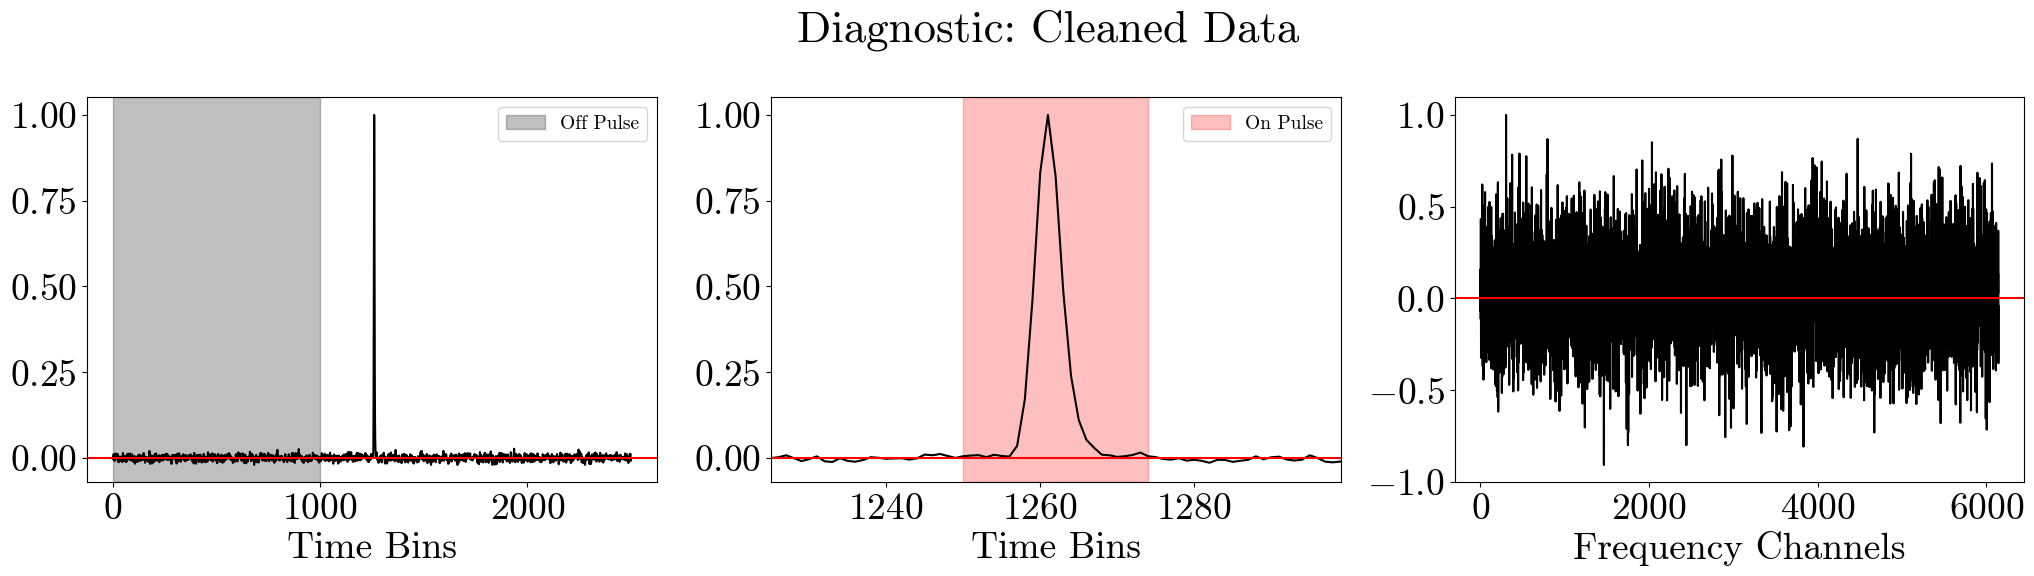

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 5))
ax1.plot(time, data_timeseries, c='k')
ax1.set_xlabel('Time Bins')
ax1.axhline(0, c = 'r')
ax1.axvspan(OFF_PULSE_INDICES_TIME[0], OFF_PULSE_INDICES_TIME[-1], alpha=0.25, color='k', label='Off Pulse')
ax1.legend(fontsize=14)

ax2.set_xlabel('Time Bins')
ax2.plot(time, data_timeseries, c='k')
ax2.set_xlim(ON_PULSE_INDICES_TIME[0]-25, ON_PULSE_INDICES_TIME[-1]+25)
ax2.axhline(0, c = 'r')
ax2.axvspan(ON_PULSE_INDICES_TIME[0], ON_PULSE_INDICES_TIME[-1], alpha=0.25, color='r', label='On Pulse')
ax2.set_xlabel('Time Bins')
ax2.legend(fontsize=14)
ax2.set_title('Diagnostic: Cleaned Data \n')

ax3.plot(data_spectrum, c='k')
ax3.axhline(0, c = 'r')
ax3.set_xlabel('Frequency Channels')

if savefigs: 
    fig.savefig('diagnostic_clean_ts_spec.pdf')

plt.show()

[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


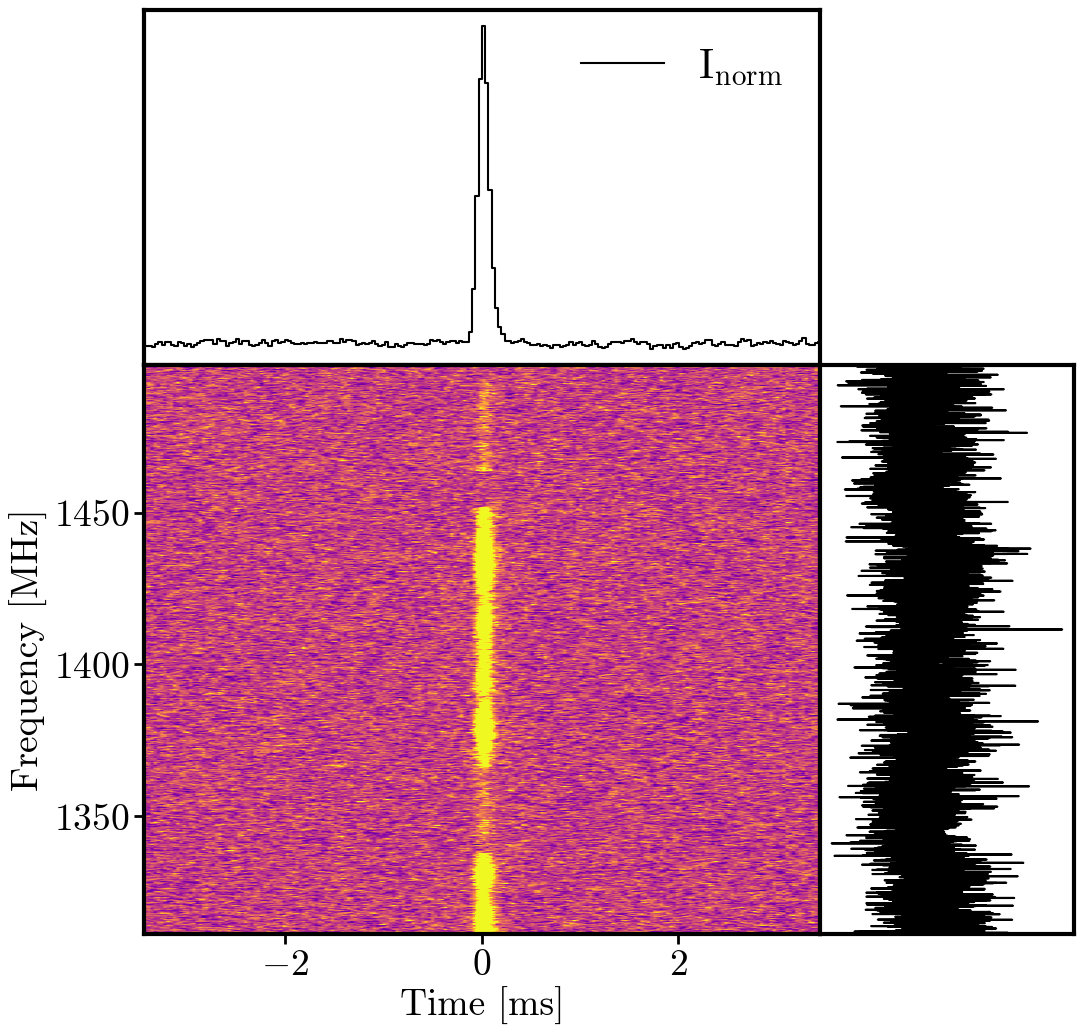

In [6]:
tres = 32.768e-3 #ms #data['delta_t (ms)']
fres = 0.03051757812 #MHz #data['delta_f (MHz)']
fres_kHz = fres*1e3
f_min = 1311.25 #MHz, the addition is to account for the 100 channels that were removed from bottom of the band
f_max = 1498.75 #MHz #data['fch1 (MHz)'] + data['df (MHz)']*data['nchans']

intensity = data_bpc #+ 3e-3 #data['I']
offintensity = intensity[:, OFF_PULSE_INDICES_TIME]
offintensity_spectrum = np.nansum(intensity[:, OFF_PULSE_INDICES_TIME], axis=1)
offintensity_timeseries = np.nansum(intensity[:, OFF_PULSE_INDICES_TIME], axis=0)

outerbound = int(intensity.shape[1] * 5.5/12)

intensity = intensity[:, outerbound:-outerbound]

# Normalize intensity
#intensity = intensity - np.nanmean(offintensity)
#intensity = intensity / np.nanstd(offintensity)
intensity_norm = intensity / np.max(intensity)

# Normalized spectrum
intensity_spectrum = np.nansum(intensity, axis=1)
intensity_spectrum = intensity_spectrum - np.nanmean(offintensity_spectrum)
intensity_spectrum = intensity_spectrum / np.nanstd(offintensity_spectrum)
spectrum_norm = intensity_spectrum / np.max(intensity_spectrum)

# Channels
freqsamples = np.linspace(f_min, f_max, spectrum_norm.shape[0])

# Normalized timeseries
intensity_timeseries = np.nansum(intensity, axis=0)
intensity_timeseries = intensity_timeseries - np.nanmean(offintensity_timeseries)
intensity_timeseries = intensity_timeseries / np.nanstd(offintensity_timeseries)
timeseries_norm = intensity_timeseries / np.max(intensity_timeseries)

# Samples
timesamples = np.linspace(0, intensity.shape[1]*tres, intensity.shape[1])
timerange = np.abs(timesamples[-1] - timesamples[0])
timesamples_center = np.linspace(-timerange/2, timerange/2, len(timesamples))
timeshift = -1 * int(timesamples_center[np.argmax(savgol_filter(timeseries_norm, 11, 3))] / tres)

# Shift intensity to center
intensity_norm = np.roll(intensity, timeshift, axis = 1)
timeseries_norm = np.roll(timeseries_norm, timeshift)


from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2], 'width_ratios':[2, 0.75]},
        figsize = (12, 12))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    print(ax_row)
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(timesamples_center, timeseries_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
#axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
axes[0, 0].set_xlim(timesamples_center[0], timesamples_center[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean = np.nanmean(intensity_norm)
std = np.nanstd(intensity_norm)
axes[1, 0].imshow(intensity_norm, vmin = mean - 1*std, vmax = mean + 1*std, extent = [timesamples_center[0], timesamples_center[-1], freqsamples[0], freqsamples[-1]], cmap = 'plasma', aspect = 'auto') 
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')
axes[1, 0].tick_params(which='both', width=2)
axes[1, 0].tick_params(which='major', length=7)
axes[1, 0].tick_params(which='minor', length=5)
axes[1, 0].tick_params(which='minor', axis = 'y', length=5)

axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

axes[1, 1].step(np.flip(spectrum_norm), freqsamples, where='pre', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[1, 1].tick_params(axis='y',
        which='both', 
        left=False, 
        right=False, 
        labelleft=False,
        width=2)
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(freqsamples[0], freqsamples[-1])

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

if savefigs: 
    fig.savefig(f'{name}_fullres_wfall.pdf', bbox_inches = 'tight')

plt.show()

Power Shape (frequency axis): 6144
Power Shape (time axis): 210
Nearest Multiple To Downsampling Factor (frequency): 6144
Nearest Multiple To Downsampling Factor (time): 210
Downsampled Data Shape: (16, 105)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


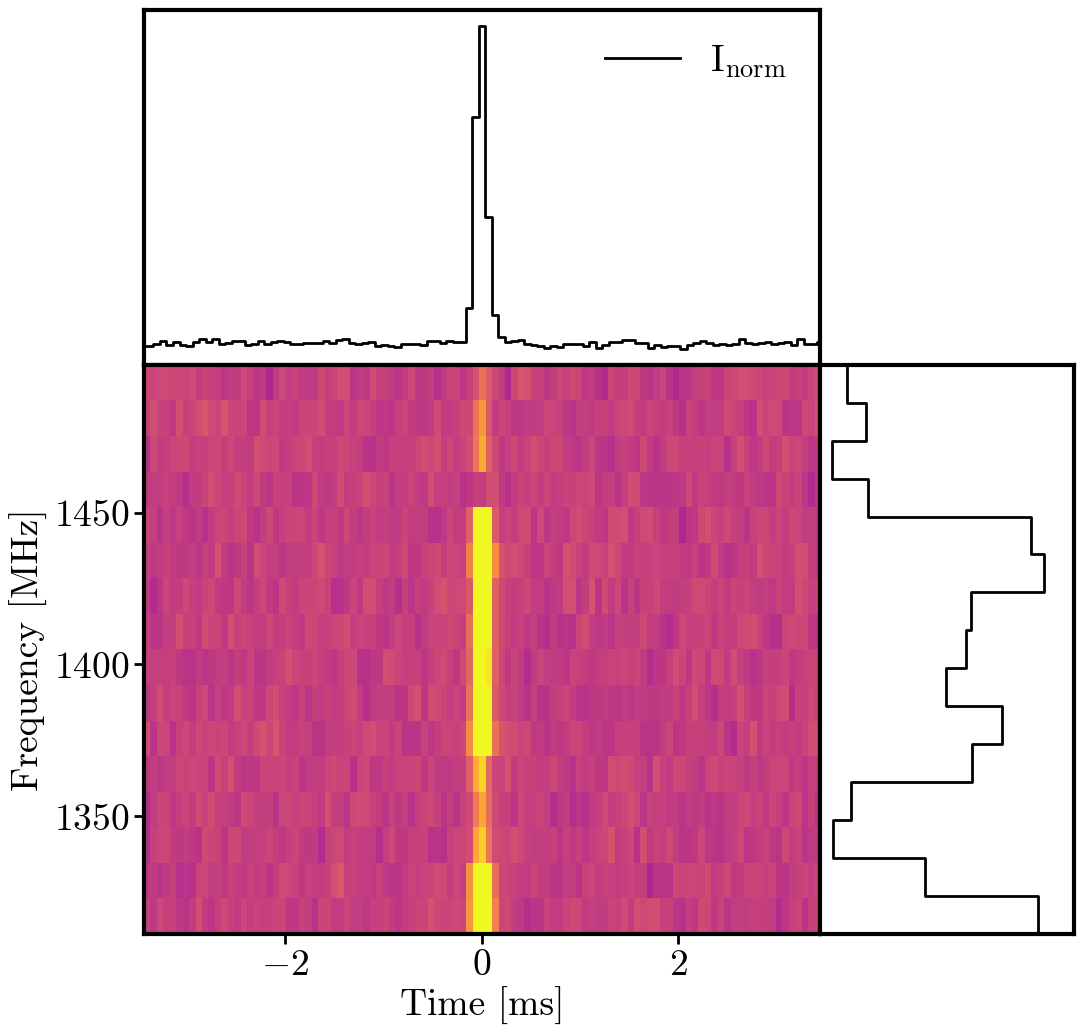

In [20]:
rcParams['font.size'] = 27

f_factor = 192*2
t_factor = 2
#intensity_ds = bft.bft.downsample_data(intensity, f_factor = f_factor, t_factor = t_factor)
intensity_ds = bft.downsample_data(intensity, f_factor = f_factor, t_factor = t_factor)

OFF_PULSE_INDICES_TIME_DS = np.arange(0, 25)
print(OFF_PULSE_INDICES_TIME_DS)

fres_ds = fres * f_factor
tres_ds = tres * t_factor

# Normalize intensity
offintensity_ds = intensity_ds[:, OFF_PULSE_INDICES_TIME_DS]
intensity_ds = intensity_ds - np.nanmean(offintensity_ds)
intensity_ds = intensity_ds / np.nanstd(offintensity_ds)
intensity_ds_norm = intensity_ds / np.max(intensity_ds)

# Normalized spectrum
intensity_spectrum_ds = np.nansum(intensity_ds, axis=1)
offintensity_spectrum_ds = np.nansum(intensity_ds[:, OFF_PULSE_INDICES_TIME_DS], axis=1)
intensity_spectrum_ds = intensity_spectrum_ds - np.nanmean(offintensity_spectrum_ds)
intensity_spectrum_ds = intensity_spectrum_ds / np.nanstd(offintensity_spectrum_ds)
spectrum_ds_norm = intensity_spectrum_ds / np.max(intensity_spectrum_ds)

# Channels
freqsamples_ds = np.linspace(f_min, f_max, spectrum_ds_norm.shape[0])

# Normalized timeseries
intensity_timeseries_ds = np.nansum(intensity_ds, axis=0)
offintensity_timeseries_ds = np.nansum(intensity_ds[:, OFF_PULSE_INDICES_TIME_DS], axis=0)
intensity_timeseries_ds = intensity_timeseries_ds - np.nanmean(offintensity_timeseries_ds)
intensity_timeseries_ds = intensity_timeseries_ds / np.nanstd(offintensity_timeseries_ds)
timeseries_ds_norm = intensity_timeseries_ds / np.max(intensity_timeseries_ds)

# Samples
timesamples_ds = np.linspace(0, intensity_ds.shape[1]*tres_ds, intensity_ds.shape[1])
timerange_ds = np.abs(timesamples_ds[-1] - timesamples_ds[0])
timesamples_center_ds = np.linspace(-timerange_ds/2, timerange_ds/2, len(timesamples_ds))
timeshift_ds = -1 * int(timesamples_center_ds[np.argmax(savgol_filter(timeseries_ds_norm, 11, 3))] / tres_ds)

# Shift intensity to center
intensity_ds_norm = np.roll(intensity_ds_norm, timeshift_ds, axis = 1)
timeseries_ds_norm = np.roll(timeseries_ds_norm, timeshift_ds)


from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2], 'width_ratios':[2, 0.75]},
        figsize = (12, 12))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    print(ax_row)
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(timesamples_center_ds, timeseries_ds_norm, where = 'mid', c = 'k', alpha = 1, linewidth=2, label = 'I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
#axes[0, 0].set_ylim(-0.75, 1.35)
axes[0, 0].set_xlim(timesamples_center_ds[0], timesamples_center_ds[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 27, frameon = False)

mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
vmin_ds = mean_ds - 3*std_ds
vmax_ds = mean_ds + 3*std_ds
axes[1, 0].imshow(intensity_ds_norm, vmin = vmin_ds, vmax = vmax_ds, extent = [timesamples_center_ds[0], timesamples_center_ds[-1], freqsamples_ds[0], freqsamples_ds[-1]], cmap = 'plasma', aspect = 'auto', interpolation='nearest') 
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')

axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

axes[1, 1].step(np.flip(spectrum_ds_norm), freqsamples_ds, where='mid', c = 'k', alpha = 1, linewidth=2)#, label = 'I$_{\mathrm{norm}}$')
axes[1, 1].tick_params(axis='y',
        which='both', 
        left=False, 
        right=False, 
        labelleft=False,
        width=2)
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(freqsamples_ds[0], freqsamples_ds[-1])

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

if savefigs: 
    fig.savefig(f'{name}_lowres_wfall_ch16.pdf', bbox_inches = 'tight')

plt.show()

In [21]:
importlib.reload(burst)

n_channels = intensity_ds_norm.shape[0]
n_samples = intensity_ds_norm.shape[1]

# Create time array (ms)
time = np.linspace(0, n_samples*tres_ds, n_samples)

# Create frequency array with 128 channels
f_b = 1.31125  # GHz
f_t = 1.49875    # GHz
freq = np.linspace(f_b, f_t, n_channels)
dm_init = 0.0 # burst already dedispersed

# Define model instance
model_instance = bft.FRBModel(intensity_ds_norm, time, freq, dm_init)


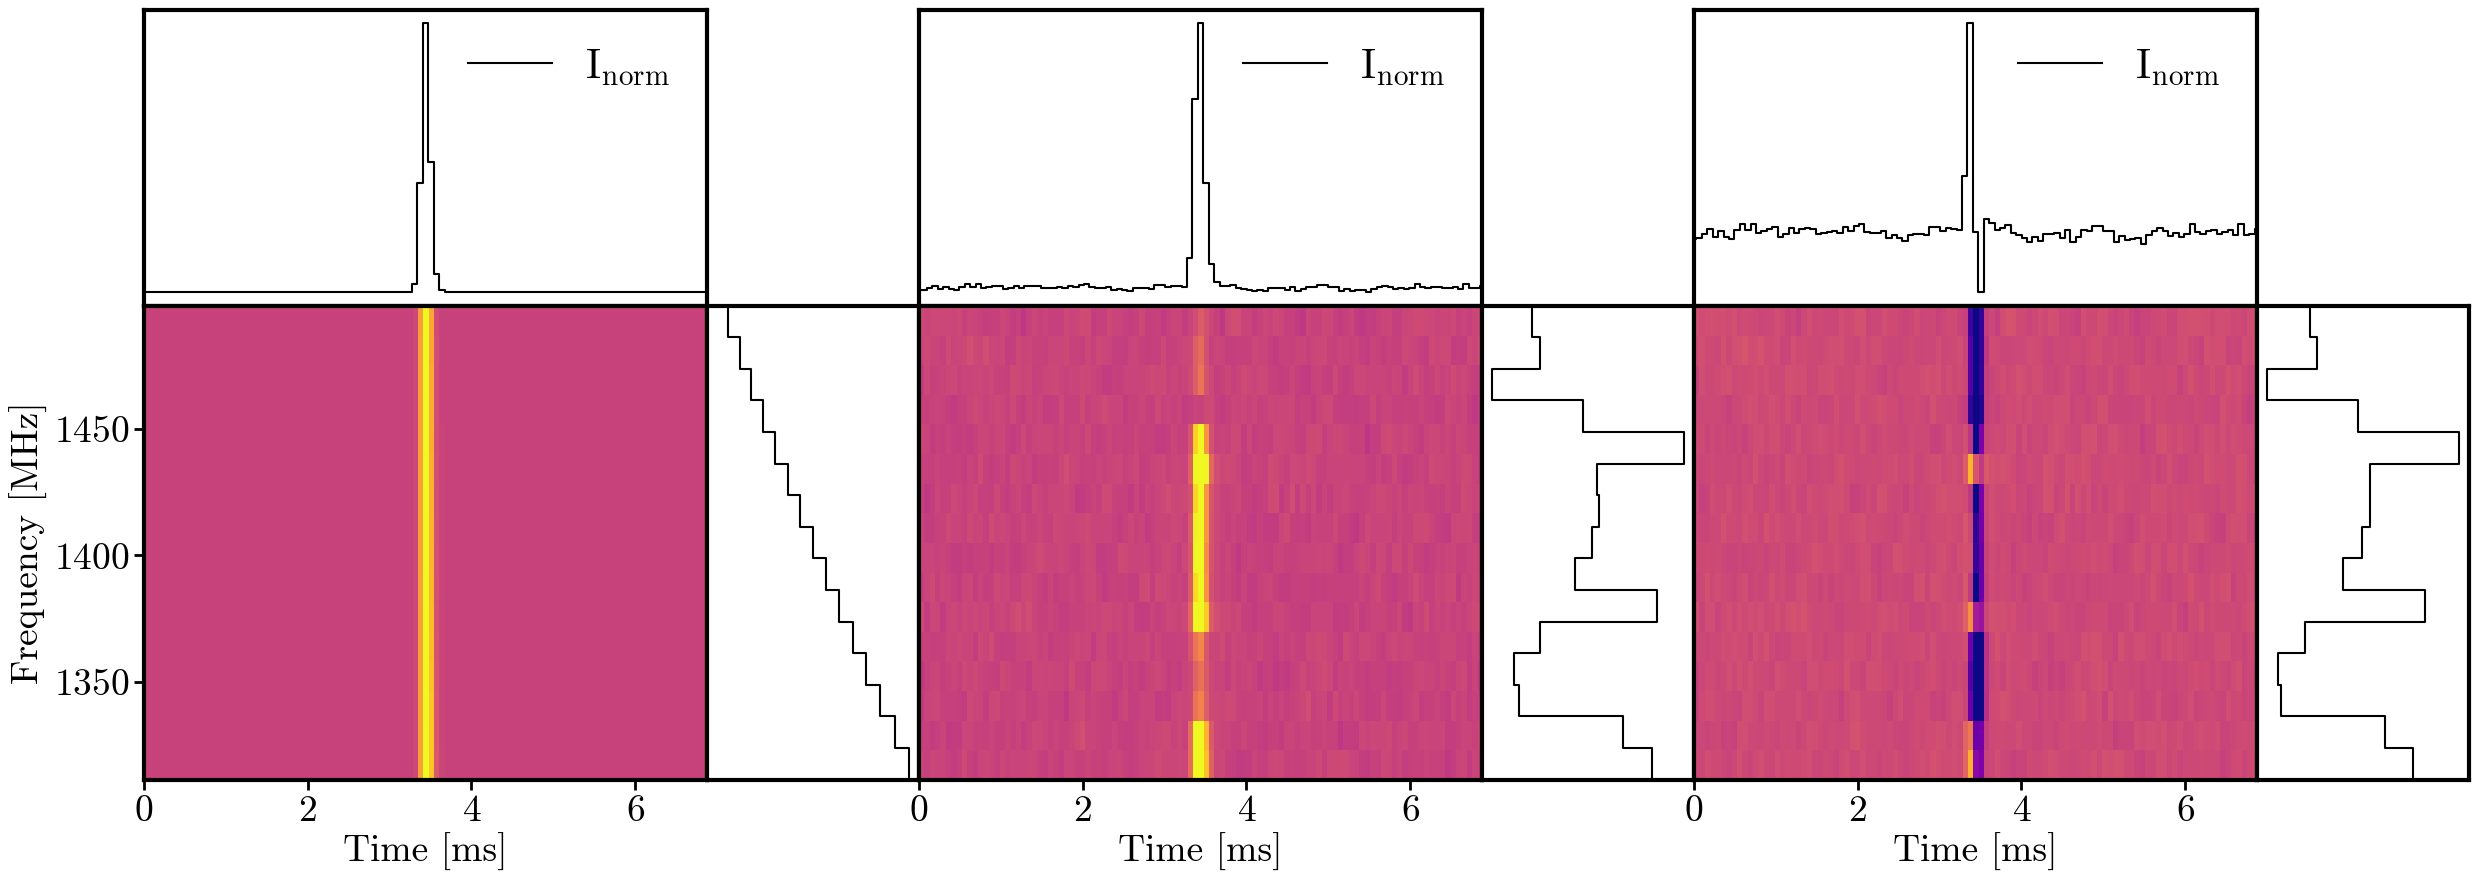

In [22]:
# Simulate "initial guess" dynamic spectrum
c0_init = np.max(np.sum(intensity_ds_norm, axis=1))# / intensity_ds_norm.shape[1]
t0_init = timesamples_ds[np.argmax(np.sum(savgol_filter(intensity_ds_norm, 11, 3), axis=0))]
gamma_init = -1
zeta_init = 0.05
tau_init = 0.1

# Assign simulation parameters
p_init = bft.FRBModelParams(c0=c0_init, t0=t0_init,
                        gamma=gamma_init, zeta=zeta_init,
                        tau_1ghz=tau_init)

# Generate dynamic spectrum
simulated_data = model_instance(p_init, model_type='M3')

simulated_data_norm = simulated_data / np.max(simulated_data)

# Set simulation resolution
sim_fres = fres_ds
sim_tres = tres_ds

sim_timeseries = np.nansum(simulated_data, axis=0)
sim_timeseries_norm = sim_timeseries / np.max(sim_timeseries)
sim_timesamples = np.linspace(0, simulated_data.shape[1]*sim_tres, simulated_data.shape[1])
sim_timerange = np.abs(sim_timesamples[-1] - sim_timesamples[0])
sim_timesamples_mod = np.linspace(-sim_timerange/2, sim_timerange/2, len(sim_timesamples))
sim_spectrum = np.nansum(simulated_data, axis=1)
sim_spectrum_norm = sim_spectrum / np.max(sim_spectrum)
sim_freqsamples = np.linspace(f_min, f_max, simulated_data.shape[0])

# Compute residuals and residual spectrum
intensity_rsdl = intensity_ds_norm - simulated_data_norm
timeseries_rsdl = timeseries_ds_norm - sim_timeseries_norm
rsdl_spectrum = np.nansum(intensity_rsdl, axis=1)
rsdl_spectrum_norm = rsdl_spectrum / np.max(rsdl_spectrum)

# Precompute means and stds for imshow vmin / vmax
sim_mean = np.nanmean(simulated_data_norm)
sim_std = np.nanstd(simulated_data_norm)
mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
mean_rsdl = np.nanmean(intensity_rsdl)
std_rsdl = np.nanstd(intensity_rsdl)

# Simulated data + Original Data + Subtracted Spectrum
fig, axes = plt.subplots(
    nrows=2, ncols=6, sharex=False, sharey=False,
    gridspec_kw={'height_ratios': [1.25, 2],
                 'width_ratios': [2, 0.75, 2, 0.75, 2, 0.75]},
    figsize=(30, 10)
)

# Increase border thickness and set tick parameters for every axis
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis='y', length=5)

# ----- PANEL 1: Simulated Data (Model) -----
# Timeseries (top left of panel 1: column 0)
axes[0, 0].step(sim_timesamples, sim_timeseries_norm, where='mid', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([])
axes[0, 0].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 0].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 0].legend(loc='upper right', fontsize=30, frameon=False)

# Waterfall (bottom left of panel 1: column 0)
axes[1, 0].imshow(simulated_data_norm,
                   vmin=sim_mean - 6*sim_std, vmax=sim_mean + 6*sim_std,
                   extent=[sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]],
                   cmap='plasma', aspect='auto')
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 1: column 1)
axes[1, 1].step(np.flip(sim_spectrum_norm), sim_freqsamples, where='pre', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
#axes[1, 1].set_xlabel('Intensity')
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(sim_freqsamples[0], sim_freqsamples[-1])
axes[1, 1].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 1)


# ----- PANEL 2: Real Data -----
# Timeseries (top left of panel 2: column 2)
axes[0, 2].step(timesamples_ds, timeseries_ds_norm, where='mid', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
axes[0, 2].set_yticks([])
axes[0, 2].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 2].set_xlim(timesamples_ds[0], timesamples_ds[-1])
axes[0, 2].legend(loc='upper right', fontsize=30, frameon=False)

# Waterfall (bottom left of panel 2: column 2)
axes[1, 2].imshow(intensity_ds_norm,
                   vmin=mean_ds - 6*std_ds, vmax=mean_ds + 6*std_ds,
                   extent=[timesamples_ds[0], timesamples_ds[-1], freqsamples_ds[0], freqsamples_ds[-1]],
                   cmap='plasma', aspect='auto')
#axes[1, 2].set_ylabel('Frequency [MHz]')
axes[1, 2].set_yticks([])
axes[1, 2].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 2: column 3)
axes[1, 3].step(np.flip(spectrum_ds_norm), freqsamples_ds, where='pre', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
#axes[1, 3].set_xlabel('Intensity')
axes[1, 3].set_xticks([])
axes[1, 3].set_ylim(freqsamples_ds[0], freqsamples_ds[-1])
axes[1, 3].tick_params(axis='y', left=False, right=False, labelleft=False)



# ----- PANEL 3: Residuals -----
# Timeseries residual (top left of panel 3: column 4)
axes[0, 4].step(sim_timesamples, timeseries_rsdl, where='mid', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
axes[0, 4].set_yticks([])
axes[0, 4].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 4].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 4].legend(loc='upper right', fontsize=30, frameon=False)

# Waterfall residual (bottom left of panel 3: column 4)
axes[1, 4].imshow(intensity_rsdl,
                   vmin=mean_rsdl - 6*std_rsdl, vmax=mean_rsdl + 6*std_rsdl,
                   extent=[sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]],
                   cmap='plasma', aspect='auto')
axes[1, 4].set_yticks([])
axes[1, 4].set_xlabel('Time [ms]')

# Residual spectrum
axes[1, 5].step(np.flip(rsdl_spectrum_norm), sim_freqsamples, where='pre', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
#axes[1, 5].set_xlabel('Intensity')
axes[1, 5].set_xticks([])
axes[1, 5].set_ylim(sim_freqsamples[0], sim_freqsamples[-1])
axes[1, 5].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide unused axes
axes[0, 1].axis('off')
axes[0, 1].set_visible(False)
axes[0, 3].axis('off')
axes[0, 3].set_visible(False)
axes[0, 5].axis('off')
axes[0, 5].set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0)

if savefigs: 
    fig.savefig(f'{name}_initmodel_threepanel_ch16.pdf', bbox_inches = 'tight')

plt.show()


In [10]:
# Define priors
prior_bounds = dict(
    c0      =(0, 3*c0_init),
    t0      =(t0_init - 0.5, t0_init + 0.5),
    gamma   =(-2*abs(gamma_init), 2*abs(gamma_init)),
    zeta    =(0, 2*zeta_init),
    tau_1ghz=(0, 2*tau_init),
)

# No. steps
nsteps = 1200

fitter   = bft.FRBFitter(model_instance, prior_bounds, n_steps=nsteps)
results  = fitter.fit(p_init, model_flags=(False, False, False, True))  # just M3
sampler  = results['M3']['sampler']

flat      = sampler.get_chain(discard=nsteps//4, flat=True)
best_vec  = flat.mean(axis=0)
best_p    = fitter._unpack(best_vec, 'M3')   # returns bft.FRBModelParams
best_model_spectrum = model_instance(best_p, model_type='M3')

M3 done (BIC 24278.5)
M3 done (BIC 24278.5)


In [12]:
# Identify best-fit model
best_model   = min(results, key=lambda m: results[m]["bic"])  # if you haven’t already
best_sampler = results[best_model]["sampler"]

print("Mean acceptance fraction (should be 0.2–0.5):",
      np.mean(best_sampler.acceptance_fraction))

# Perform chain sanity check
log_probs = best_sampler.get_log_prob()
if np.any(~np.isfinite(log_probs)):
    print("Found NaN or ±Inf in log-probabilities!")

# Flatten chain (discard burn-in)
burn_in  = nsteps // 4     # first 25% of samples discarded
samples  = best_sampler.get_chain(discard=burn_in, flat=True)
log_prob = best_sampler.get_log_prob(discard=burn_in, flat=True)

# Parameter bookkeeping
param_map = {              # indices in the flattened sample vector
    "M0": (0, 1, 2),       # c0, t0, gamma
    "M1": (0, 1, 2, 3),    # + zeta
    "M2": (0, 1, 2, 3),    # + tau_1ghz
    "M3": (0, 1, 2, 3, 4), # + zeta + tau_1ghz
}
relevant_samples = samples[:, param_map[best_model]]

# Legible labels
labels = ["c0", "t0", "gamma"] # base parameters
if best_model in {"M1", "M3"}:
    labels.append("zeta")
if best_model in {"M2", "M3"}:
    labels.append("tau_1ghz")


Mean acceptance fraction (should be 0.2–0.5): 0.30041666666666667


In [14]:
# Calculate parameter estimates and their uncertainties
best_fit_params = []
best_fit_params_dict = {}
lower_err = []
upper_err = []
for i, label in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{label} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")
    best_fit_params.append(mcmc[1])
    lower_err.append(-q[0])
    upper_err.append(+q[1])
    best_fit_params_dict[f'{label}'] = (mcmc[1], +q[1], -q[0])

# Generate simulated data
initial_params = {}
initial_params['c0_init'] = c0_init
initial_params['t0_init'] = t0_init
initial_params['gamma_init'] = gamma_init
#initial_params['DM_err_init'] = DM_err_init
initial_params['zeta_init'] = zeta_init
initial_params['tau_init'] = tau_init
#initial_params['alpha_init'] = alpha_init

best_fit_params_dict['initial_params'] = initial_params
best_fit_params_dict['prior_bounds'] = prior_bounds


c0 = 0.064 (+0.001, -0.001)
t0 = 3.426 (+0.001, -0.001)
gamma = -1.996 (+0.893, -0.003)
zeta = 0.059 (+0.001, -0.001)
tau_1ghz = 0.016 (+0.017, -0.011)


Best Fit Params: [0.06418844689270436, 3.4260018506942944, -1.9961835849310527, 0.058625067968767264, 0.016461736538452634]


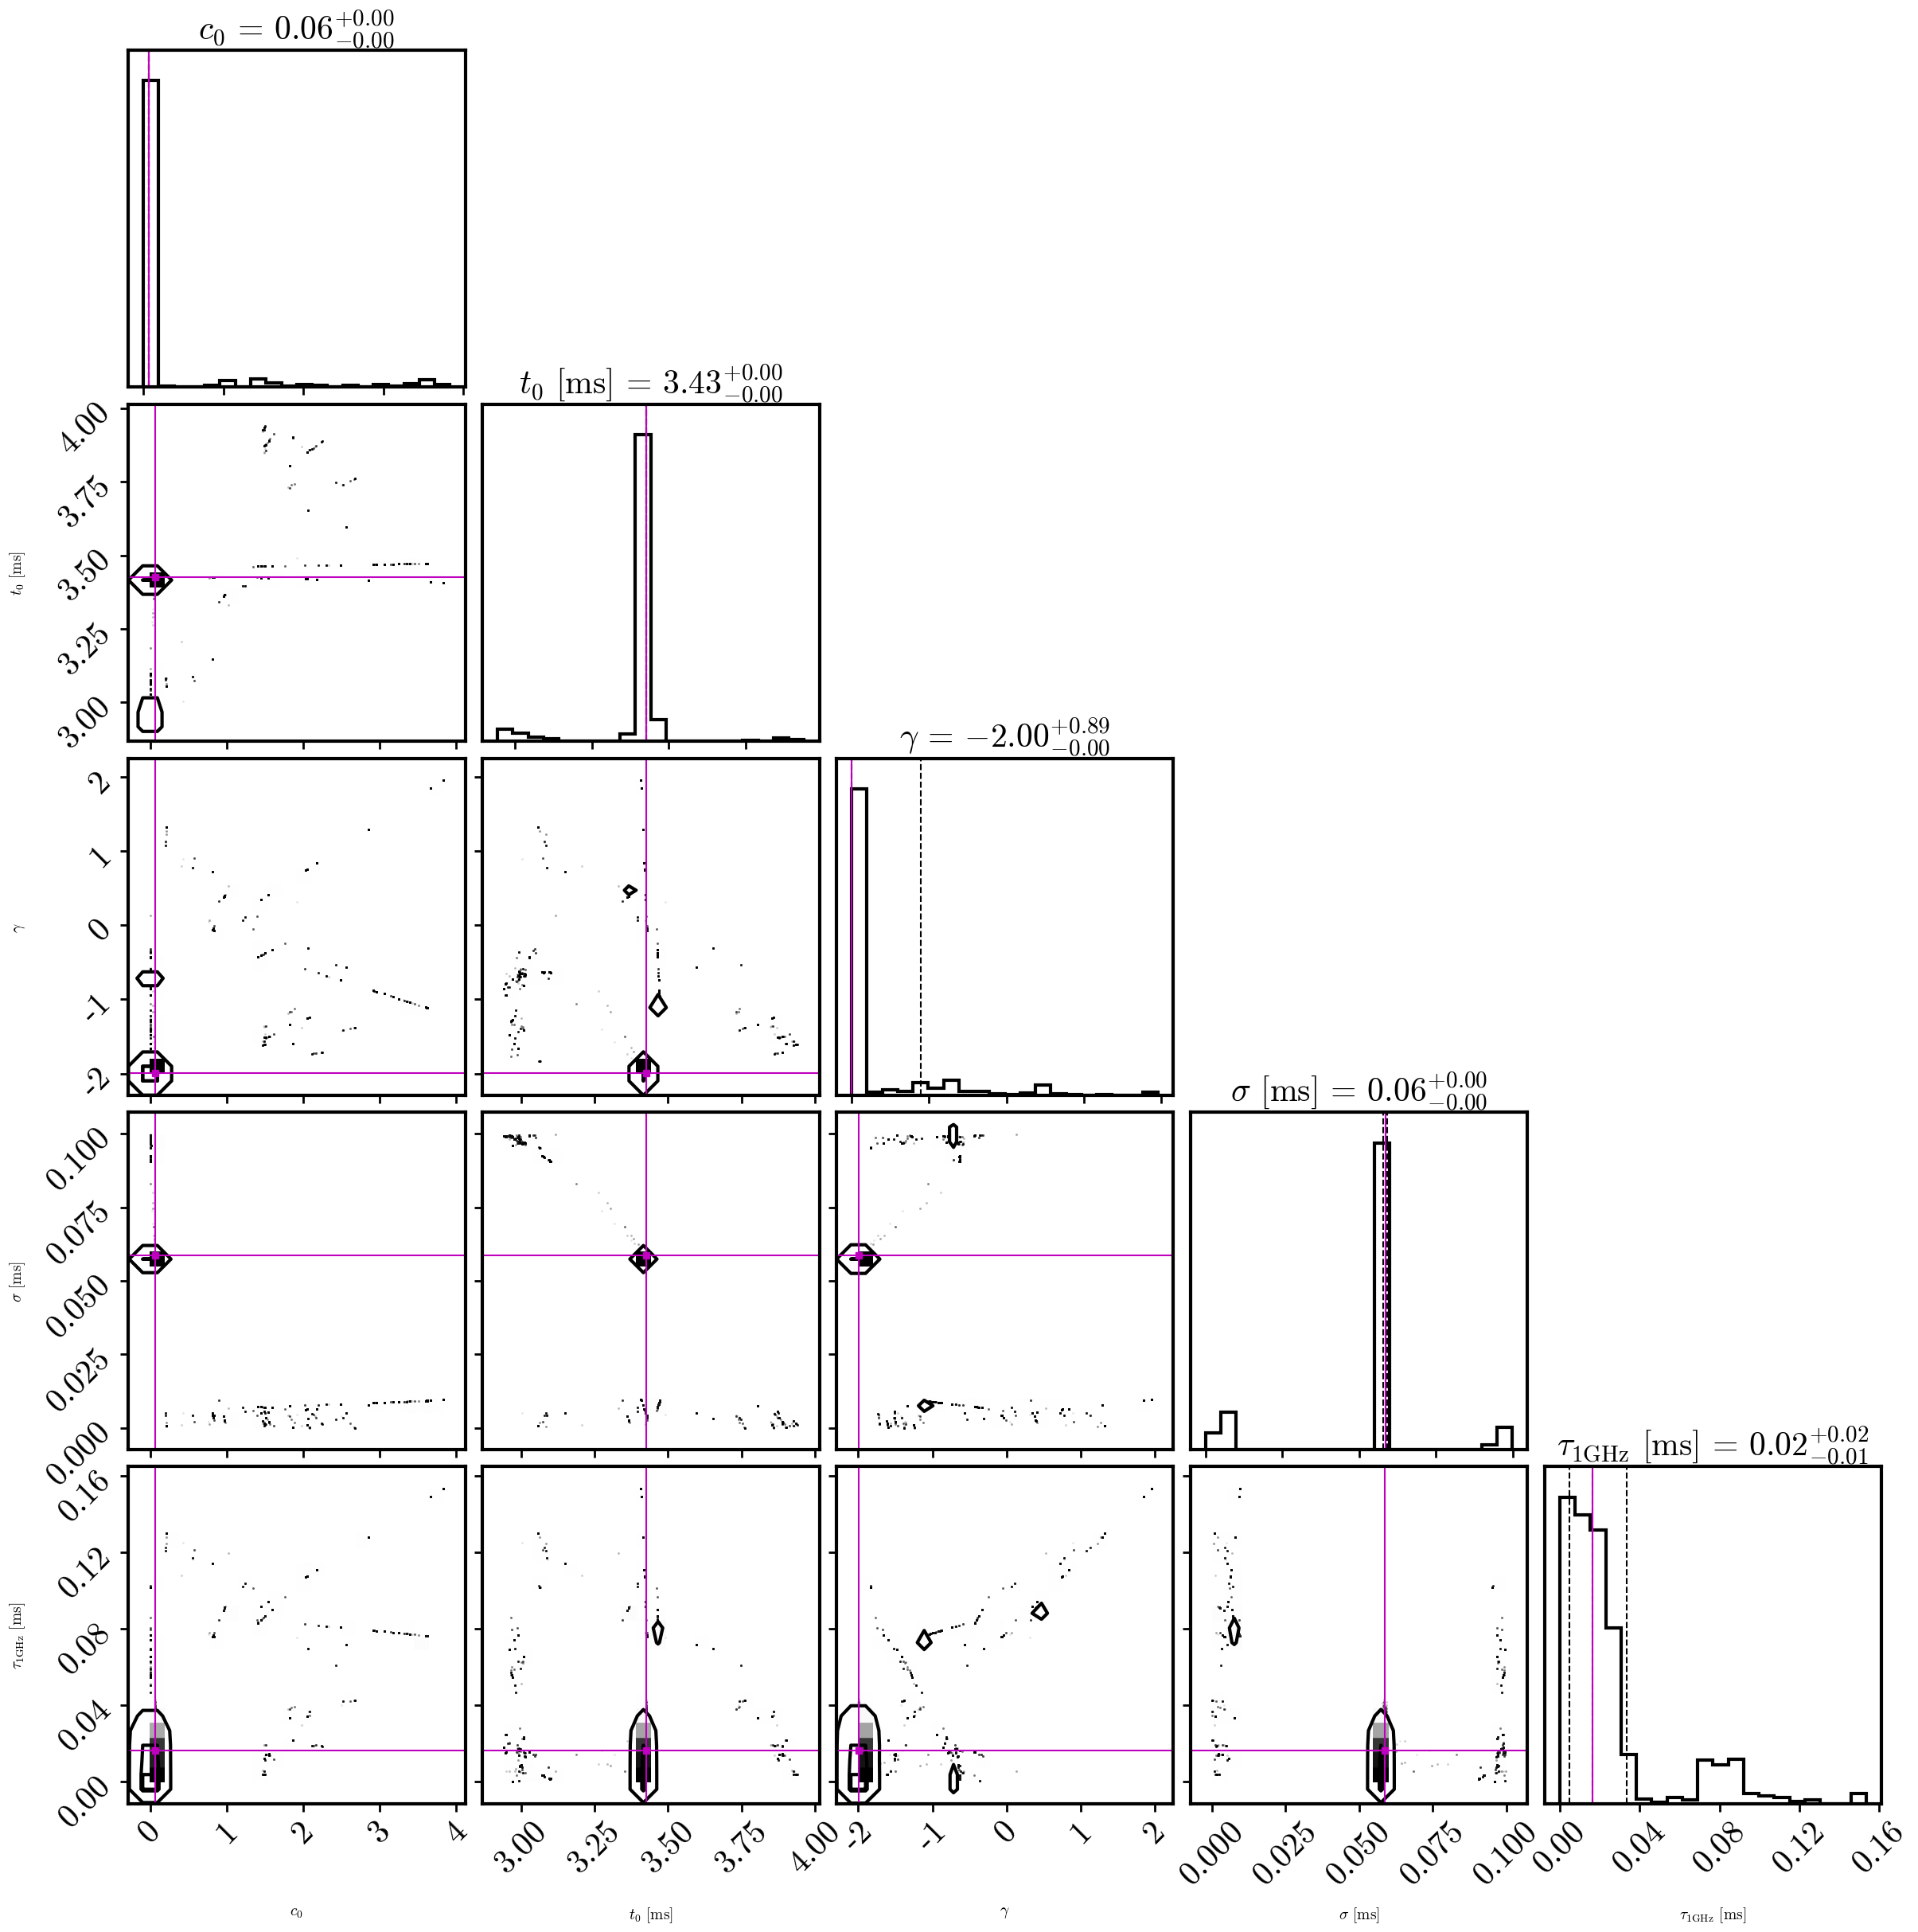

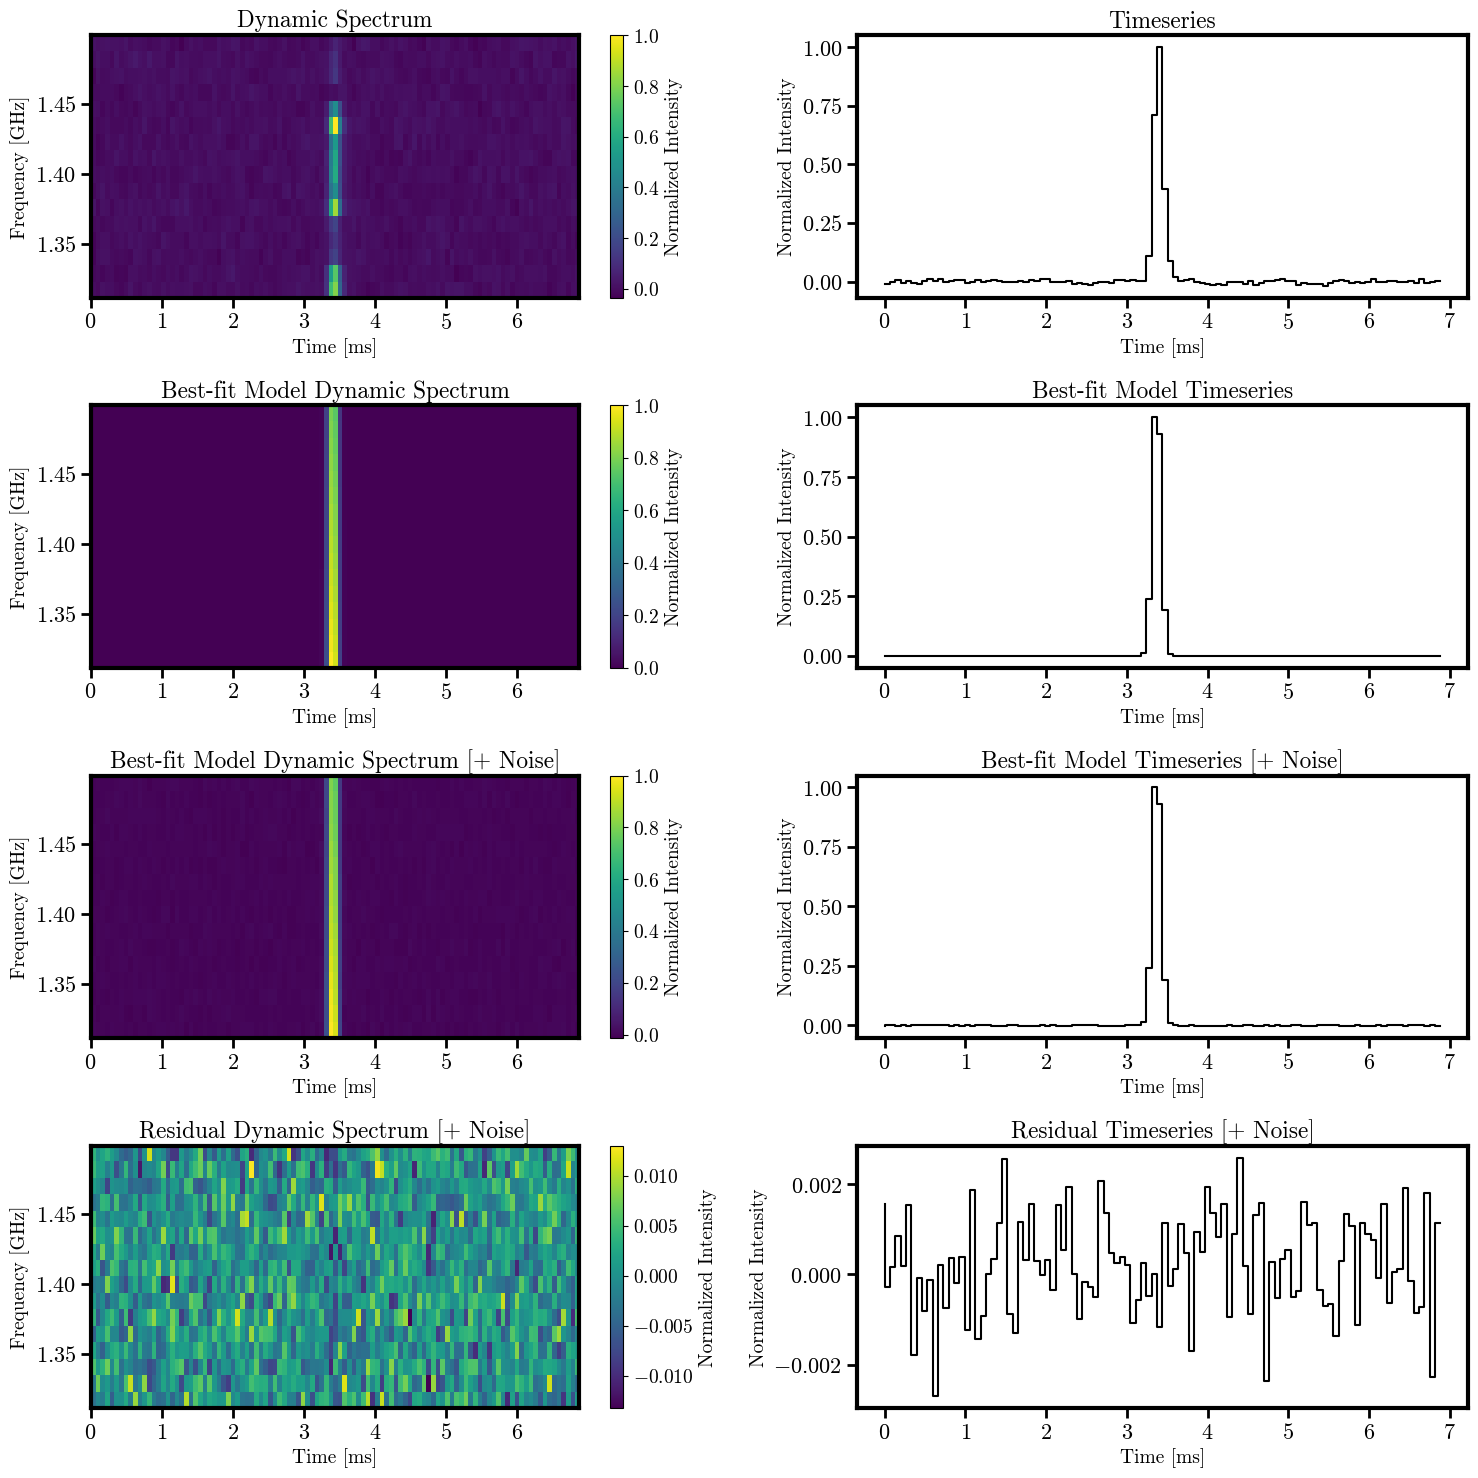

Mean acceptance fraction: 0.30041666666666667


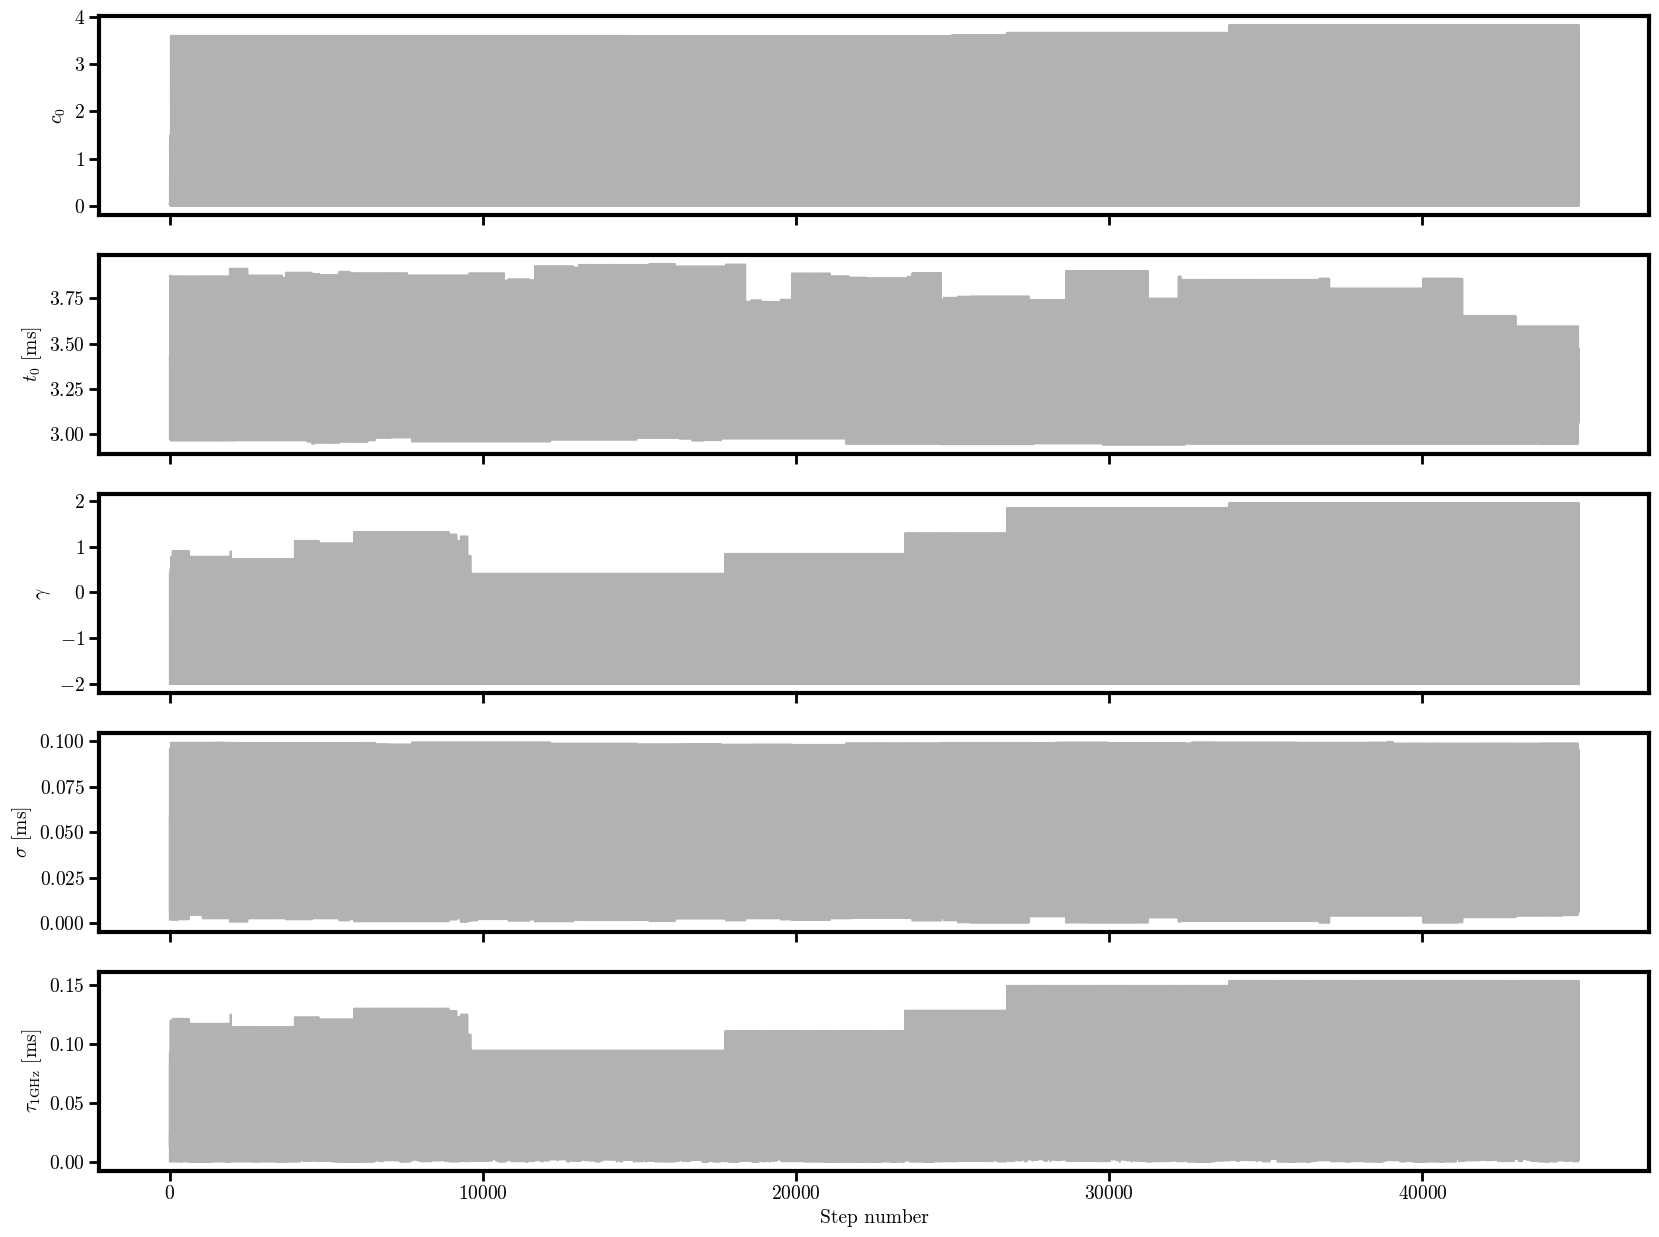

In [18]:
# Plot the data and the best-fit model
#best_fit_index = np.argmax(best_sampler.get_log_prob(discard=burn_in, flat=True))
#best_fit_index = np.argmax(log_prob)
#best_fit_params = samples[best_fit_index]

print(f'Best Fit Params: {best_fit_params}')

rcParams['font.size'] = 14

# Plot the corner plot
# Define figure size before creating the corner plot
fig = plt.figure(figsize=(25, 25))  # Adjust width and height

labels = [r'$c_0$', r'$t_0$ [ms]', r'$\gamma$', r'$\sigma$ [ms]', r'$\tau_\mathrm{1GHz}$ [ms]']

#ranges = [(0, 1), (126, 127.5), (-2.2, 2.2), (0, 1.75), (50, 110)]

fig = corner.corner(relevant_samples, labels=labels, truths=best_fit_params, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 30}, fig=fig, truth_color='m', hist_kwargs={'linewidth': 3, 'histtype': 'step'}, contour_kwargs={'linewidths': 3})

for ax in fig.axes:
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)
    ax.tick_params(axis='both', labelsize=30)

fig.savefig(f'{name}_corner_ch16.pdf', bbox_inches = 'tight')
plt.show()

# Compute the model spectrum using the best-fit parameters
#best_fit_model = model_instance.model(best_fit_params, model_type=best_model)
best_fit_model = model_instance(best_p, model_type=best_model)      # <-- new API

# Normalized data
model_data = best_fit_model
model_offdata = model_data[:, OFF_PULSE_INDICES_TIME_DS]
model_offdata_spectrum = np.nansum(model_offdata, axis=1)
model_offdata_timeseries = np.nansum(model_offdata, axis=0)

norm_model = model_data - np.nanmean(model_offdata)
norm_model = norm_model / np.nanstd(model_offdata)
norm_model = norm_model / np.max(norm_model)

model_data_timeseries = np.nansum(model_data, axis=0)
norm_model_timeseries = model_data_timeseries - np.nanmean(model_offdata_timeseries)
norm_model_timeseries = norm_model_timeseries / np.nanstd(model_offdata_timeseries)
norm_model_timeseries = norm_model_timeseries / np.max(norm_model_timeseries)

model_data_spectrum = np.sum(model_data, axis=1)
norm_model_spectrum = model_data_spectrum - np.nanmean(model_offdata_spectrum)
norm_model_spectrum = norm_model_spectrum / np.nanstd(model_offdata_spectrum)
norm_model_spectrum = norm_model_spectrum / np.max(norm_model_spectrum)

# Plot the data and the best-fit model separately for comparison
fig = plt.figure(figsize=(15, 15))

for i in range(1, 9):
    plt.subplot(4, 2, i)
    ax = plt.gca()
    
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)
    ax.tick_params(axis='both', labelsize=16)

# Plot the data
plt.subplot(4, 2, 1)
extent = [time[0], time[-1], freq[0], freq[-1]]
plt.imshow(intensity_ds_norm, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Dynamic Spectrum')

plt.subplot(4, 2, 2)
plt.step(time, timeseries_ds_norm, c='k')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Timeseries')

# Plot the best-fit model
plt.subplot(4, 2, 3)
plt.imshow(norm_model, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
#plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Best-fit Model Dynamic Spectrum')

plt.subplot(4, 2, 4)
plt.step(time, norm_model_timeseries, c='k')
#plt.plot(time, norm_noisy_timeseries)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries')

# Plot the best-fit model with added noise (based on the original data)
# Generate synthetic noise with the same shape as the model
#noise_sigma = model_instance.noise_std
#noise = np.random.lognormal(mean=0.0, sigma=noise_sigma[:, np.newaxis], size=best_fit_model.shape)
noise_sigma = model_instance.noise_std                             # renamed
#noise = np.random.normal(loc=0.0, scale=model_instance.noise_std[:, np.newaxis], size=best_fit_model.shape)
noise = np.random.lognormal(mean=0.0,
                            sigma=noise_sigma[:, None],
                            size=best_fit_model.shape)


# Add the synthetic noise to the fitted model
noisy_model = best_fit_model + noise #savgol_filter(noise, 7, 3)
noisy_offmodel = noisy_model[:, OFF_PULSE_INDICES_TIME_DS]
norm_noisy_model = noisy_model - np.mean(noisy_offmodel)
norm_noisy_model = norm_noisy_model / np.nanstd(noisy_offmodel)
norm_noisy_model = norm_noisy_model / np.max(norm_noisy_model)

# Integrate to get the noisy timeseries
noisy_timeseries = np.nansum(norm_noisy_model, axis = 0)
noisy_offtimeseries = np.nansum(norm_noisy_model[:, OFF_PULSE_INDICES_TIME_DS], axis = 0)
norm_noisy_timeseries = noisy_timeseries - np.mean(noisy_offtimeseries)
norm_noisy_timeseries = norm_noisy_timeseries / np.nanstd(noisy_offtimeseries)
norm_noisy_timeseries = norm_noisy_timeseries / np.max(norm_noisy_timeseries)

# Integrate to get the noisy spectrum
noisy_spectrum = np.nansum(norm_noisy_model, axis = 1)
noisy_offspectrum = np.nansum(norm_noisy_model[:, OFF_PULSE_INDICES_TIME_DS], axis = 1)
norm_noisy_spectrum = noisy_spectrum - np.mean(noisy_offspectrum)
norm_noisy_spectrum = norm_noisy_spectrum / np.nanstd(noisy_offspectrum)
norm_noisy_spectrum = norm_noisy_spectrum / np.max(norm_noisy_spectrum)

plt.subplot(4, 2, 5)
#plt.imshow(norm_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Best-fit Model Dynamic Spectrum [+ Noise]')

plt.subplot(4, 2, 6)
#plt.plot(time, norm_model_timeseries)
plt.step(time, norm_noisy_timeseries, c='k')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries [+ Noise]')

# Plot the residuals
plt.subplot(4, 2, 7)
plt.imshow(norm_model - norm_noisy_model, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Residual Dynamic Spectrum [+ Noise]')

plt.subplot(4, 2, 8)
plt.step(time, norm_model_timeseries - norm_noisy_timeseries, c='k')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Residual Timeseries [+ Noise]')

plt.tight_layout()

#fig.savefig(f'{name}_finalmodel_eightpanel.pdf', bbox_inches = 'tight')

plt.show()

# Check the mean acceptance fraction
print("Mean acceptance fraction:", np.mean(best_sampler.acceptance_fraction))

# Trace plots to assess convergence
ndim = len(labels)
fig, axes = plt.subplots(ndim, figsize=(20, 15), sharex=True)
for i in range(ndim):
    axes[i].plot(samples[:, i], "k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    # Spine widths
    axes[i].spines['top'].set_linewidth(3)
    axes[i].spines['bottom'].set_linewidth(3)
    axes[i].spines['left'].set_linewidth(3)
    axes[i].spines['right'].set_linewidth(3)

    # Tick parameters
    axes[i].tick_params(which='both', width=2)
    axes[i].tick_params(which='major', length=7)
    axes[i].tick_params(which='minor', length=5)
    axes[i].tick_params(which='minor', axis='y', length=5)
axes[-1].set_xlabel("Step number")

#fig.savefig(f'{name}_traces_ch16.pdf', bbox_inches = 'tight')

plt.show()


In [ ]:
# For Plotting & Normalization
time_plot = np.linspace(0, intensity_ds_norm.shape[1]*tres_ds, intensity_ds_norm.shape[1])
#print(time_plot.shape)
time_plot_center = np.linspace(-1*time_plot[-1]//2, time_plot[-1]//2, intensity_ds_norm.shape[1])
freq_plot = np.linspace(f_b, f_t, intensity_ds_norm.shape[0])
#print(freq_plot.shape)
#model_instance_plot = bft.bft.FRBModel(intensity_ds_norm, time_plot, freq_plot, dm_init)
model_instance_plot = bft.FRBModel(
    data=intensity_ds_norm,   # same normalised data you plot
    time=time_plot,           # ms axis you defined above
    freq=freq_plot,           # GHz axis you defined above
    dm_init=dm_init,
)

best_fit_model_plot = model_instance_plot(best_p, model_type=best_model)
best_fit_offmodel_plot = best_fit_model_plot[:, OFF_PULSE_INDICES_TIME_DS]
best_fit_offmodel_timeseries = np.nansum(best_fit_offmodel_plot, axis=0)
best_fit_offmodel_spectrum = np.nansum(best_fit_offmodel_plot, axis=1)
#print(best_fit_model_plot.shape)

# Normalized model
model_plot = best_fit_model_plot - np.nanmean(best_fit_offmodel_plot)
norm_model_plot = model_plot / np.nanstd(best_fit_offmodel_plot)
norm_model_plot = norm_model_plot / np.max(norm_model_plot)

model_timeseries_plot = np.nansum(norm_model_plot, axis = 0)
norm_model_timeseries_plot = model_timeseries_plot - np.mean(best_fit_offmodel_timeseries)
norm_model_timeseries_plot = norm_model_timeseries_plot / np.nanstd(best_fit_offmodel_timeseries)
norm_model_timeseries_plot = norm_model_timeseries_plot / np.max(norm_model_timeseries_plot)

model_spectrum_plot = np.nansum(norm_model_plot, axis = 1)
norm_model_spectrum_plot = model_spectrum_plot - np.mean(best_fit_offmodel_spectrum)
norm_model_spectrum_plot = norm_model_spectrum_plot / np.nanstd(best_fit_offmodel_spectrum)
norm_model_spectrum_plot = norm_model_spectrum_plot / np.max(norm_model_spectrum_plot)

fig, axes = plt.subplots(
    nrows=2, ncols=8, sharex=False, sharey=False,
    gridspec_kw={'height_ratios': [1.25, 2],
                 'width_ratios': [2, 0.75, 2, 0.75, 2, 0.75, 2, 0.75]},
    figsize=(40, 10)
)

rcParams['font.size'] = 40

# Increase border thickness and set tick parameters for every axis
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis='y', length=5)


extent = [-((time_plot[-1] - time_plot[0])//2), (time_plot[-1] - time_plot[0])//2, freq_plot[0], freq_plot[-1]]

# ----- PANEL 1: Real Data -----
# Timeseries (top left of panel 1: column 0)
axes[0, 0].step(time_plot, timeseries_ds_norm, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{data}}$')
axes[0, 0].set_yticks([])
axes[0, 0].set_ylim(-0.75, 2)
axes[0, 0].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 0].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 0].legend(loc='upper right', fontsize=30, frameon=False)
#axes[0, 0].text(1.4, 1.4, r'$mathbf{A}$', color='k', fontsize=35)

# Waterfall (bottom left of panel 1: column 0)
axes[1, 0].imshow(intensity_ds_norm, extent=extent, vmin = -0.5, vmax = 1, cmap='plasma', aspect='auto', interpolation='nearest')
axes[1, 0].set_ylabel('Frequency [GHz]')
axes[1, 0].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 1: column 1)
axes[1, 1].step(np.flip(spectrum_ds_norm), freq_plot, where='mid', c='k', alpha=1, linewidth=2)
#axes[1, 1].set_xlabel('Intensity')
axes[1, 1].set_xticks([])
axes[1, 1].set_xlim(-2, 4)
axes[1, 1].set_ylim(freq[0], freq[-1])
axes[1, 1].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 1)
axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

# ----- PANEL 2: Simulated Data (Model) -----
# Timeseries (top left of panel 1: column 0)
axes[0, 2].step(time_plot, norm_model_timeseries_plot, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{model}}$')
axes[0, 2].set_yticks([])
axes[0, 2].set_ylim(-0.75, 2)
axes[0, 2].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 2].set_xlim(time[0], time[-1])
axes[0, 2].legend(loc='upper right', fontsize=35, frameon=False)
#axes[0, 2].text(1.4, 1.4, r'$\mathbf{B}$', color='k', fontsize=35)

# Waterfall (bottom left of panel 1: column 0)
axes[1, 2].imshow(norm_model, extent=extent, cmap='plasma', aspect='auto', interpolation='nearest')
axes[1, 2].set_xlabel('Time [ms]')
axes[1, 2].set_yticks([])

# Spectrum (bottom right of panel 1: column 1)
axes[1, 3].step(np.flip(norm_model_spectrum), freq_plot, where='mid', c='k', alpha=1, linewidth=2)
axes[1, 3].set_xticks([])
axes[1, 3].set_xlim(-4, 8)
axes[1, 3].set_ylim(freq[0], freq[-1])
axes[1, 3].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 1)
axes[0, 3].axis('off')
axes[0, 3].set_visible(False)

# ----- PANEL 3: Simulated Data + Noise -----
# Timeseries (top left of panel 2: column 2)
axes[0, 4].step(time_plot, norm_noisy_timeseries, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{model+noise}}$')
axes[0, 4].set_yticks([])
axes[0, 4].set_ylim(-0.75, 2)
axes[0, 4].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 4].set_xlim(time[0], time[-1])
axes[0, 4].legend(loc='upper right', fontsize=35, frameon=False)
#axes[0, 4].text(0.4, 1.4, r'$\mathbf{C}$', color='k', fontsize=35)

# Waterfall (bottom left of panel 2: column 2)
axes[1, 4].imshow(norm_noisy_model, extent=extent, vmin = -0.5, vmax = 1, cmap='plasma', aspect='auto', interpolation='nearest')
axes[1, 4].set_yticks([])
axes[1, 4].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 2: column 3)
axes[1, 5].step(np.flip(norm_noisy_spectrum), freq_plot, where='mid', c='k', alpha=1, linewidth=2)
#axes[1, 3].set_xlabel('Intensity')
axes[1, 5].set_xticks([])
axes[1, 5].set_xlim(-4, 8)
axes[1, 5].set_ylim(freq[0], freq[-1])
axes[1, 5].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 3)
axes[0, 5].axis('off')
axes[0, 5].set_visible(False)

# ----- PANEL 4: Residuals -----
# Timeseries residual (top left of panel 3: column 4)
axes[0, 6].step(time_plot, timeseries_ds_norm - norm_noisy_timeseries, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{residual}}$')
axes[0, 6].set_yticks([])
axes[0, 6].set_ylim(-0.75, 2)
axes[0, 6].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 6].set_xlim(time[0], time[-1])
axes[0, 6].legend(loc='upper right', fontsize=35, frameon=False)
#axes[0, 6].text(1.4, 1.4, r'$\mathbf{D}$', color='k', fontsize=35)

# Waterfall residual (bottom left of panel 3: column 4)
axes[1, 6].imshow(intensity_ds_norm - norm_noisy_model, extent=extent, vmin = -0.5, vmax = 1, cmap='plasma', aspect='auto', interpolation='nearest')
#axes[1, 4].set_ylabel('Frequency [MHz]')
axes[1, 6].set_yticks([])
axes[1, 6].set_xlabel('Time [ms]')

# Spectrum for residuals (bottom right of panel 3: column 5)
axes[1, 7].step(np.flip(spectrum_ds_norm - norm_noisy_spectrum), freq, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{norm}}$')
axes[1, 7].set_xticks([])
axes[1, 7].set_xlim(-4, 8)
axes[1, 7].set_ylim(freq[0], freq[-1])
axes[1, 7].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 5)
axes[0, 7].axis('off')
axes[0, 7].set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0)

fig.savefig(f'{name}_finalmodel_fourpanel_ch16.pdf', bbox_inches = 'tight')

plt.show()

print('Best Fit Parameters: \n')
from pprint import pprint
pprint(best_fit_params_dict)
